<a href="https://colab.research.google.com/github/tnusser/ImageRetrieval/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [66]:
import tensorflow as tf
import numpy as np
import sklearn
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Conv2DTranspose, Reshape, LeakyReLU
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence, plot_model
import keras.backend as K 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import umap
import pandas as pd
import sklearn.metrics.pairwise
from google.colab import files
import skimage as ski
from skimage import util, transform

## 3.1 Dataset Preparation

In [3]:
 # Loading the dataset
 (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
# Converting the dataset
x_train = (raw_x_train/255).astype("float32")
x_test = (raw_x_test/255).astype("float32")
y_test = np.concatenate(raw_y_test).ravel()

In [ ]:
# Checking the results
print(x_train.shape)
print(x_test.shape)
print(raw_y_train.shape)
print(raw_y_test.shape)

## 3.2 Building the Autoencoder

In [12]:
# Encoder Model
i = Input(shape=(32, 32, 3), name="input_layer")
e1 = Conv2D(32, (3, 3), padding='same', name="conv_1")(i)
e2 = LeakyReLU(alpha=0.1)(e1)
e3 = Conv2D(64, (3, 3), padding='same', strides=(1,1))(e2)
e4 = LeakyReLU(alpha=0.1)(e3)
e5 = Conv2D(128, (3, 3), padding='same', strides=(2,2))(e4)
e6 = LeakyReLU(alpha=0.1)(e5)
e7 = Flatten()(e6)
e8 = Dense(10, name="latent_space")(e7)
e9 = LeakyReLU(alpha=0.1)(e8)

#Decoder Model
conv_shape = K.int_shape(e1)
d_i = Input(shape=(10,))
d1 = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3],)(d_i)
d2 = LeakyReLU(alpha=0.1)(d1)
d3 = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(d2)
d4 = Conv2DTranspose(filters=16, kernel_size=3, padding="same")(d3)
d5 = LeakyReLU(alpha=0.1)(d4)
d6 = Conv2DTranspose(filters=3, kernel_size=3, activation="sigmoid", padding="same")(d5)

encoder = Model(i, e9, name='encoder')
encoder.summary()
decoder = Model(d_i, d6, name='decoder')
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 16, 16, 128)       0   

In [13]:
# Combining encoder and decoder to autoencoder model
autoencoder_outputs = decoder(encoder(i))
autoencoder = Model(i, autoencoder_outputs, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              (None, 10)                420938    
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         365507    
Total params: 786,445
Trainable params: 786,445
Non-trainable params: 0
_________________________________________________________________


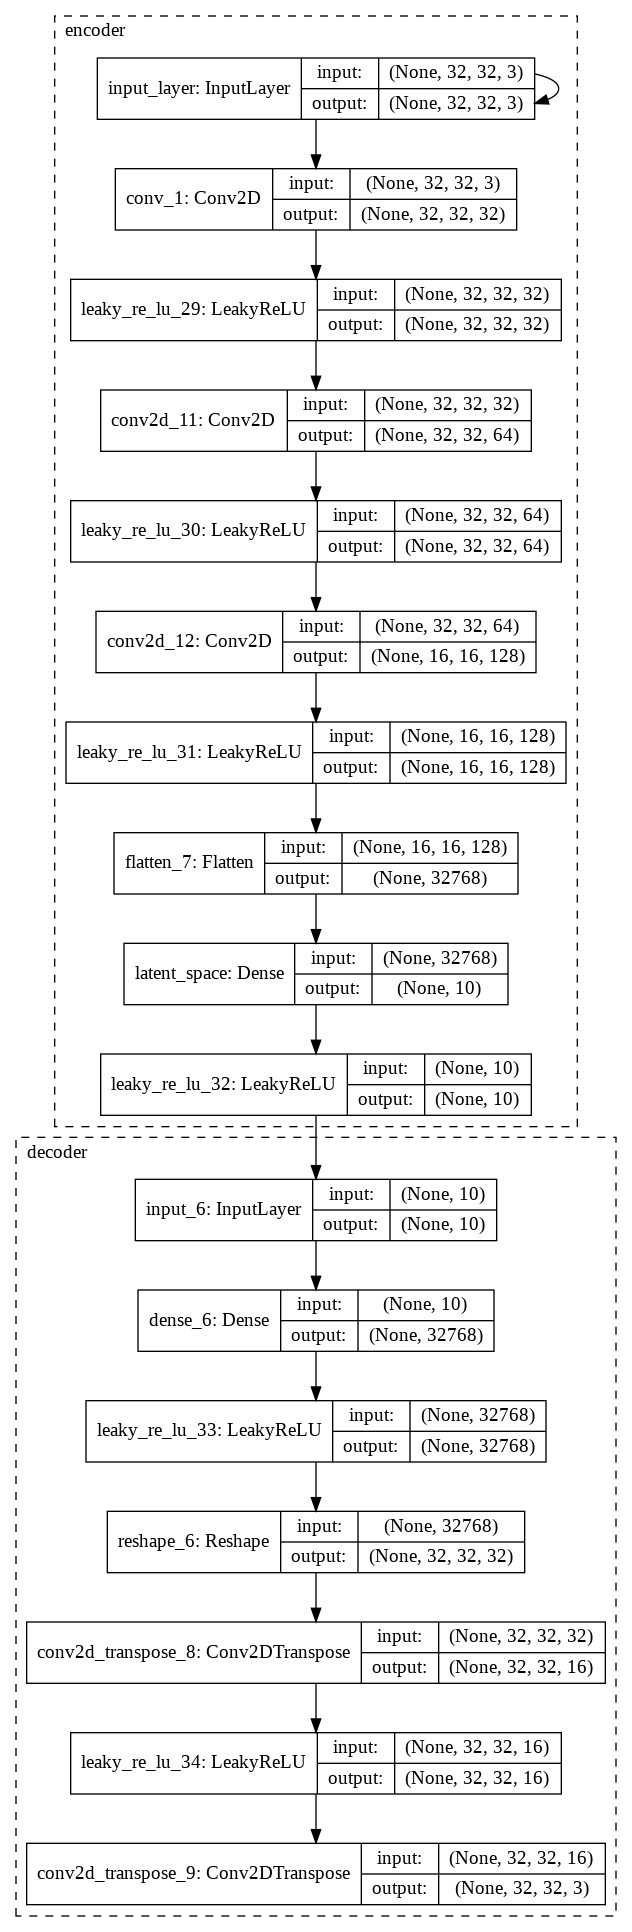

In [19]:
# Plotting the neural network architecture
plot_model(
    autoencoder,
    to_file="autoencoder.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## 3.3 Training the Autoencoder

In [5]:
# Splitting the data in validation and training data
x_val = x_train[:4600]
x_train = x_train[4600:]

In [14]:
checkpoint = ModelCheckpoint('best.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = autoencoder.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=50, batch_size=512, callbacks=[checkpoint, earlystopping])

Train on 45400 samples, validate on 4600 samples
Epoch 1/50
45400/45400 [==============================] - 378s 8ms/step - loss: 0.0413 - accuracy: 0.4485 - val_loss: 0.0266 - val_accuracy: 0.4982

Epoch 00001: val_accuracy improved from -inf to 0.49820, saving model to best.hdf5
Epoch 2/50
45400/45400 [==============================] - 372s 8ms/step - loss: 0.0243 - accuracy: 0.5474 - val_loss: 0.0223 - val_accuracy: 0.5955

Epoch 00002: val_accuracy improved from 0.49820 to 0.59548, saving model to best.hdf5
Epoch 3/50
45400/45400 [==============================] - 366s 8ms/step - loss: 0.0219 - accuracy: 0.5900 - val_loss: 0.0217 - val_accuracy: 0.5985

Epoch 00003: val_accuracy improved from 0.59548 to 0.59855, saving model to best.hdf5
Epoch 4/50
45400/45400 [==============================] - 376s 8ms/step - loss: 0.0216 - accuracy: 0.5953 - val_loss: 0.0216 - val_accuracy: 0.5898

Epoch 00004: val_accuracy did not improve from 0.59855
Epoch 5/50
45400/45400 [=====================

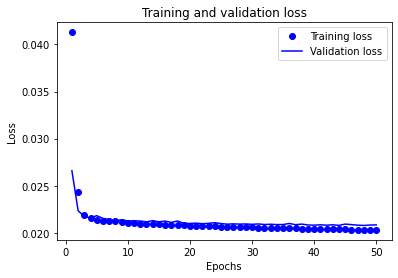

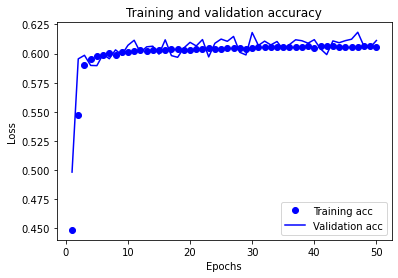

In [15]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Downloading the best performing model
files.download('best.hdf5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4 Sanity Check

In [23]:
# Loading best performing model weights and predict test set
autoencoder.load_weights("best.hdf5")
predictions = autoencoder.predict(x_test)

## 4.1 Visualizing Reconstruction Results 

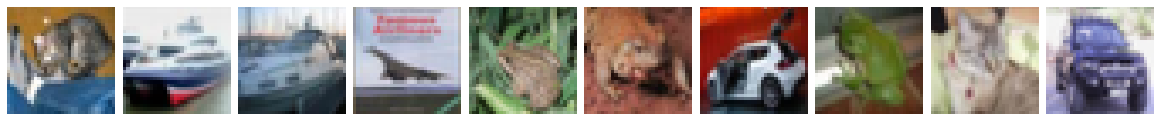

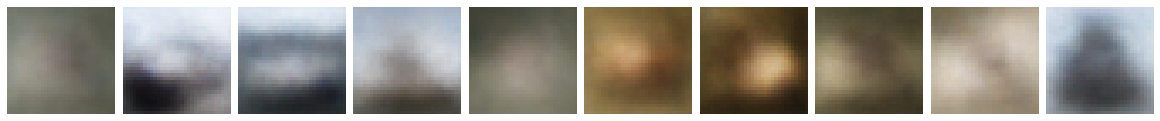

In [24]:
f, axarr = plt.subplots(1, 10, constrained_layout=True)
f.set_size_inches(16, 6)
for i in range(10):
    original = x_test[i]
    axarr[i].imshow(original)
    axarr[i].axis('off')
f, axarr = plt.subplots(1, 10, constrained_layout=True)
f.set_size_inches(16, 6)
for i in range(10):
    prediction = predictions[i]
    axarr[i].imshow(prediction)
    axarr[i].axis('off')
plt.show()

## 4.2 Distribution Analysis

In [25]:
# Sampling 50 random images from the testset
samples = random.sample(list(x_test), 50)
latent_space_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoder").get_layer("latent_space").output)
# Latent space of test images
latent_spaces = latent_space_layer_model.predict(np.asarray(samples))

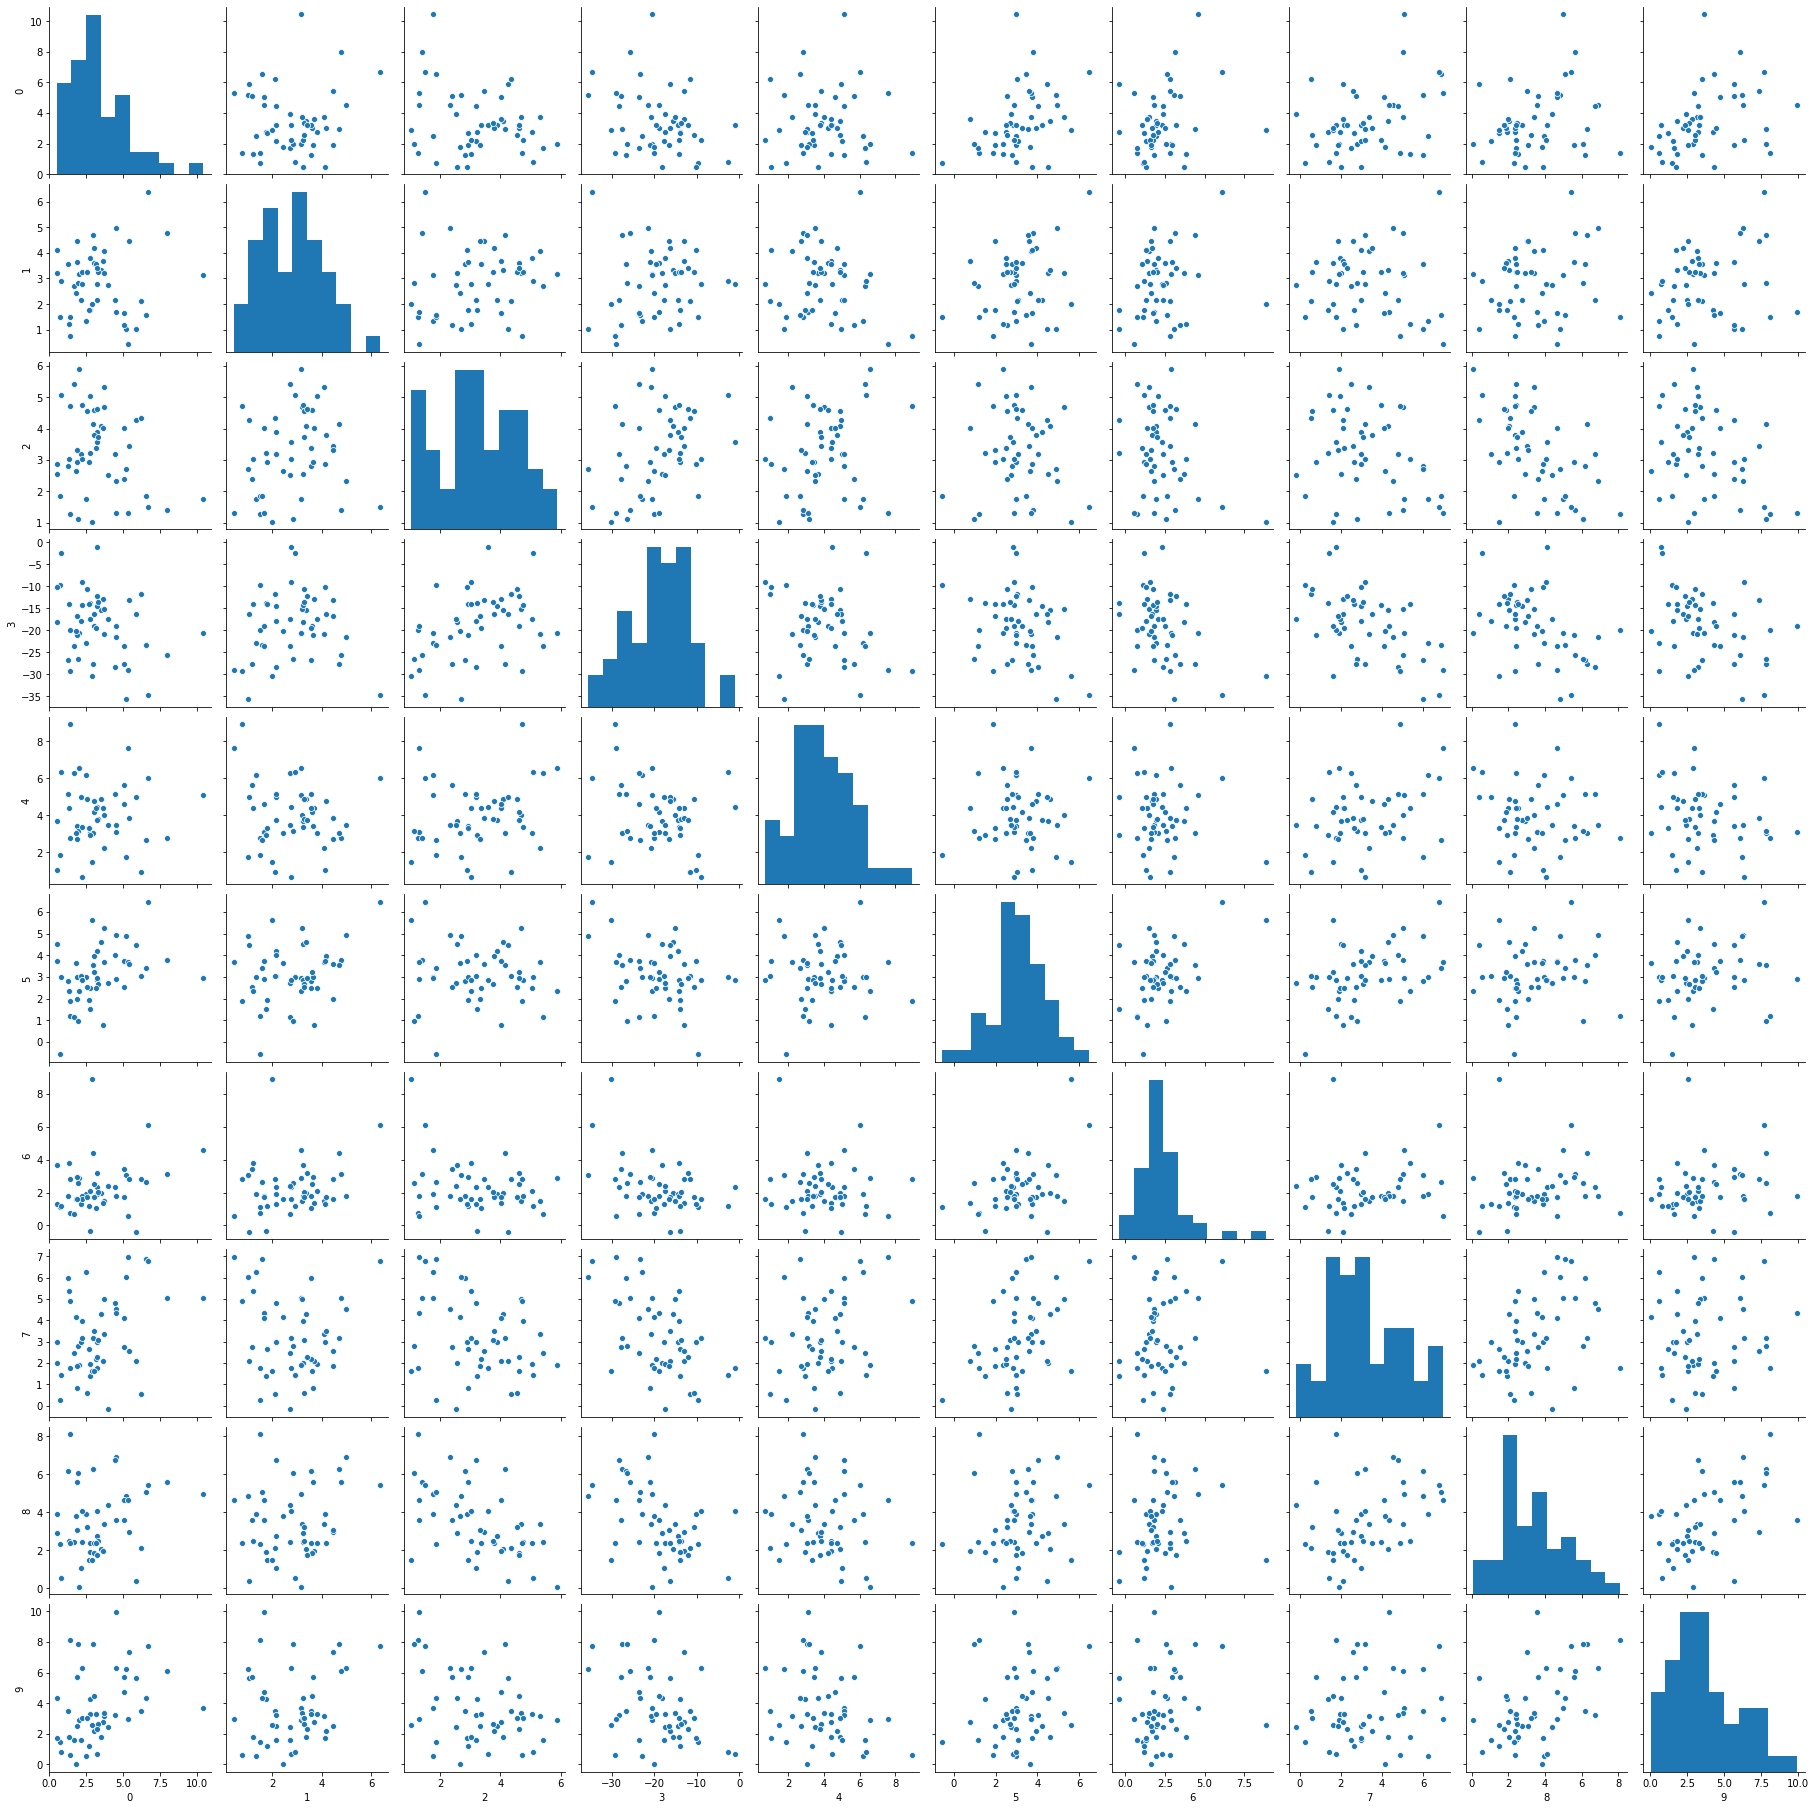

In [27]:
# Visualizing latentspaces
df = pd.DataFrame(latent_spaces)
sns.pairplot(df)

## 4.3 Projecting Results

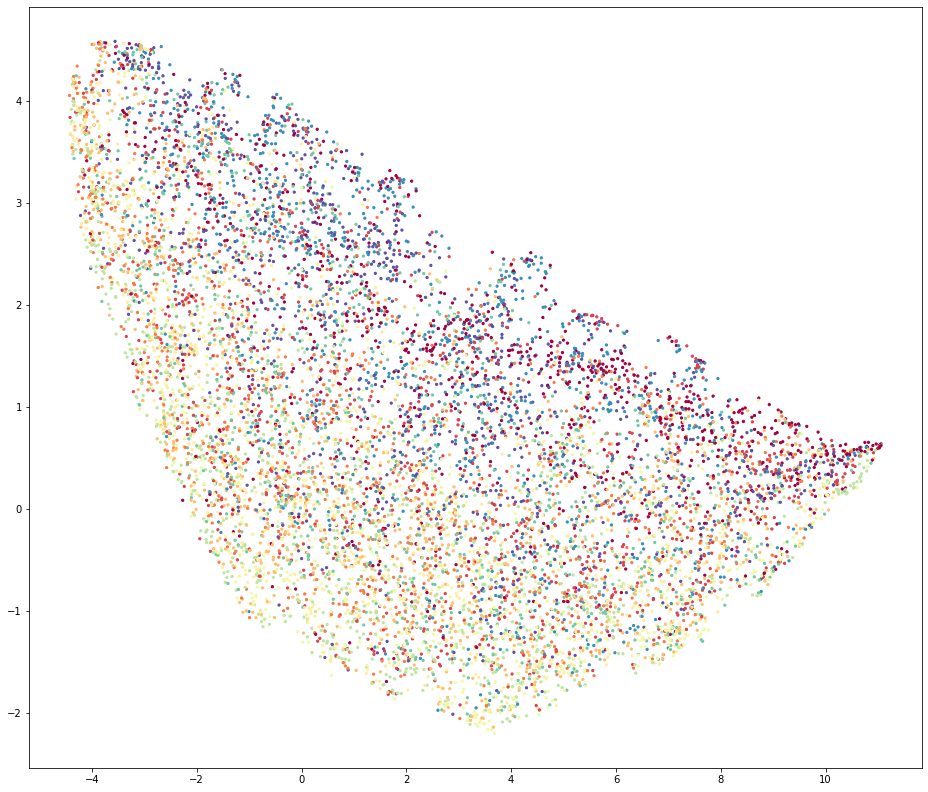

In [28]:
# Visualizing latentspace vectors for all test images using UMAP
all_latentspaces = latent_space_layer_model.predict(x_test)
trans = umap.UMAP().fit(all_latentspaces)
plt.figure(figsize=(16, 14))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_test, cmap='Spectral')

## 5 Data Querying

In [29]:
# Retrieving 20 random test images to query
query_image_tuple= random.sample(list(enumerate(x_test)), 20)
query_images = []
for query_image in query_image_tuple:
  query_images.append(query_image[1])

In [31]:
# Latent space vector for all query images
query_images_latentspace = latent_space_layer_model.predict(np.asarray(query_images))
# Concatenating train and testset
data = np.concatenate((x_train, x_test), axis = 0)
train_test_latentspaces = latent_space_layer_model.predict(data)

First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


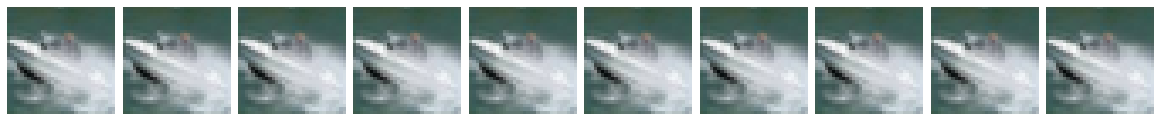

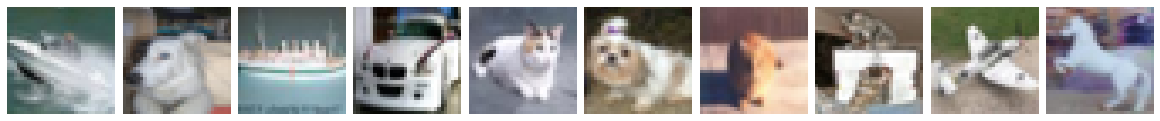

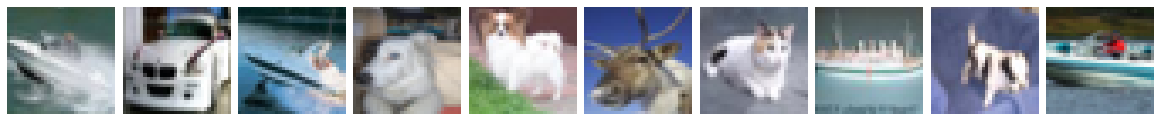

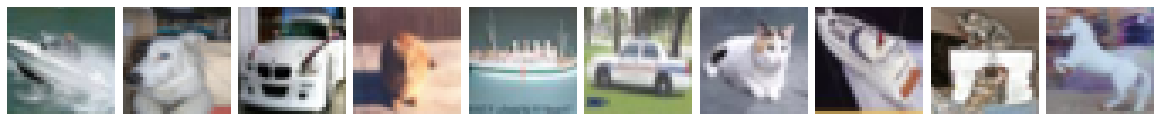




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


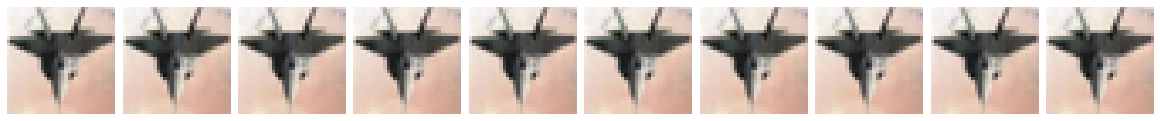

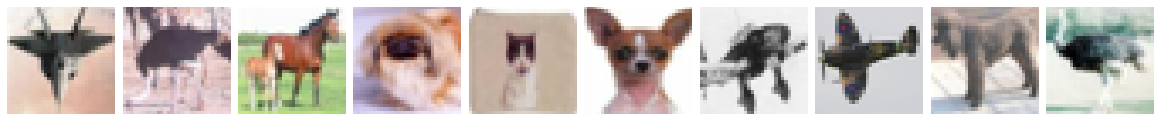

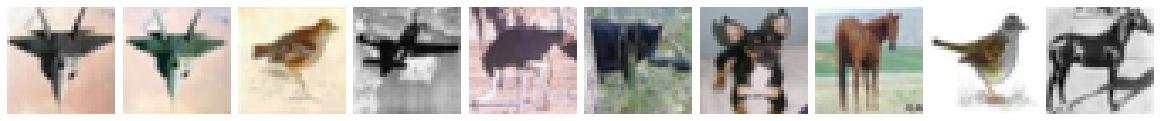

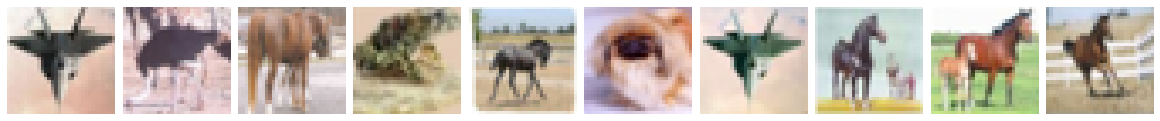




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


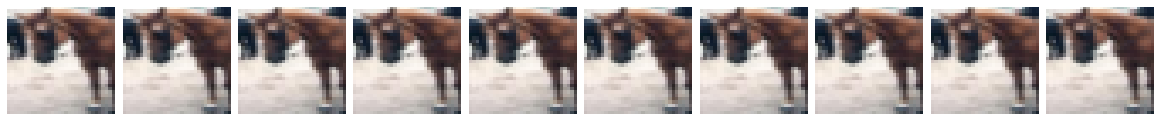

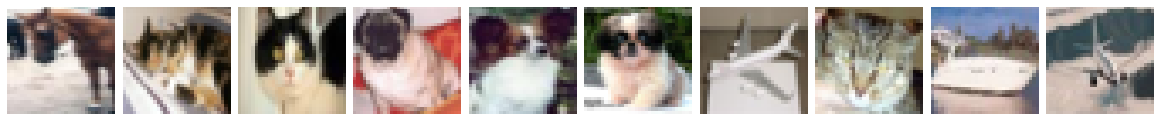

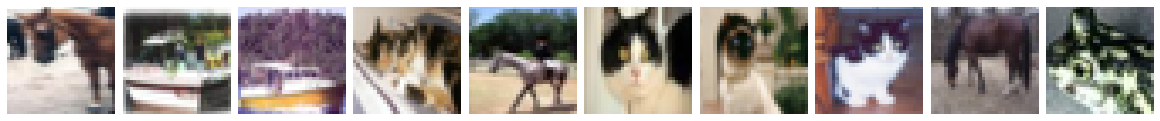

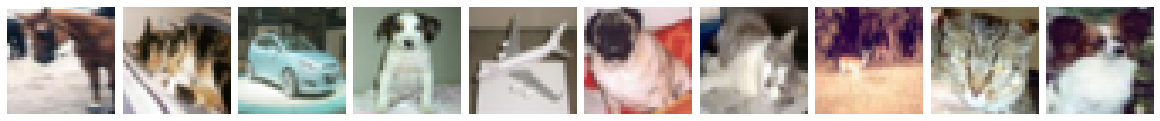




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


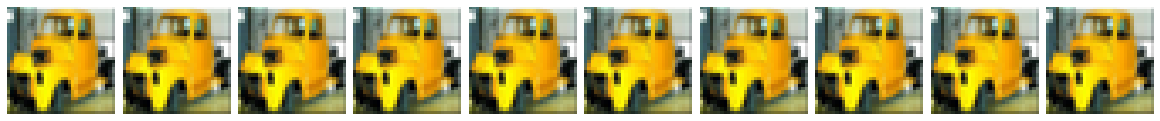

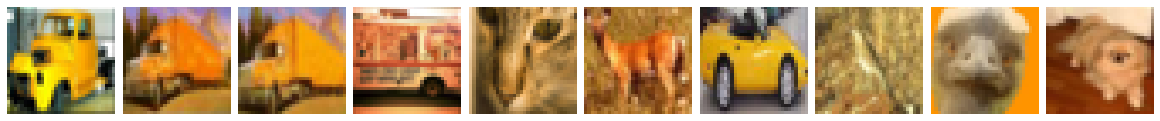

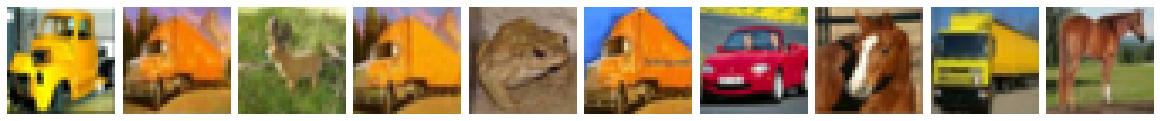

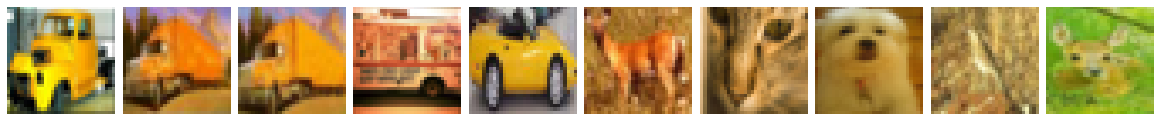




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


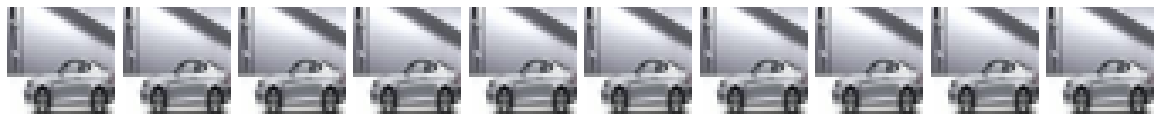

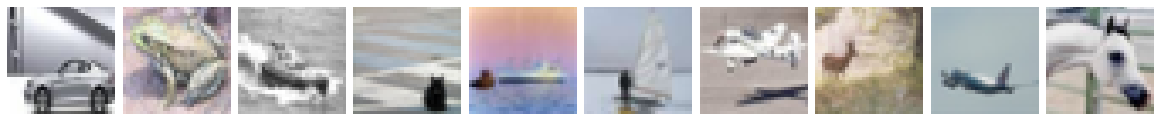

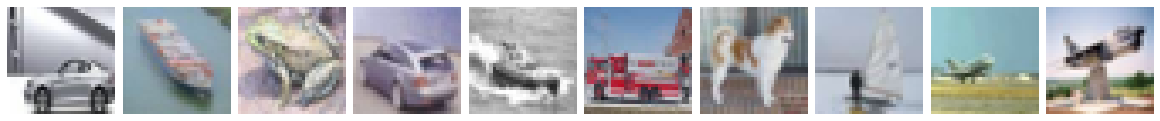

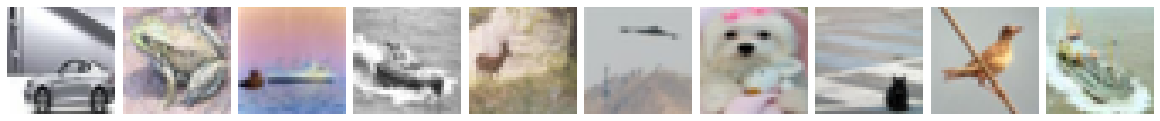




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


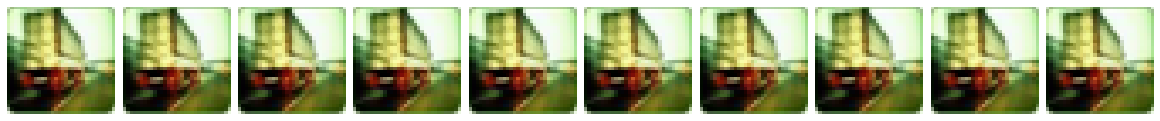

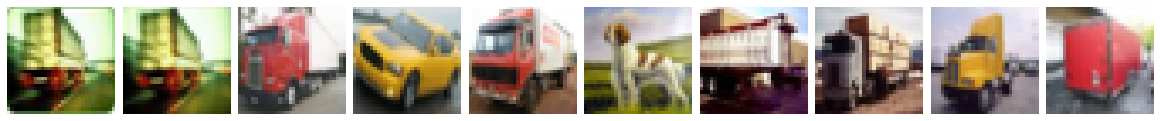

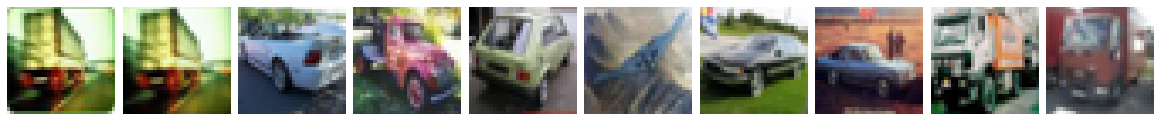

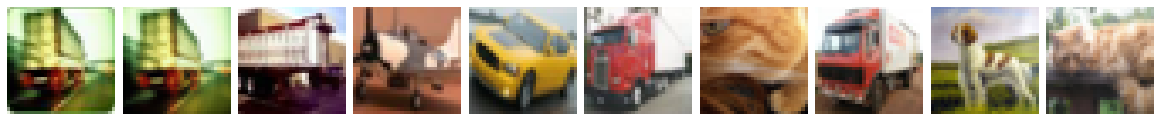




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


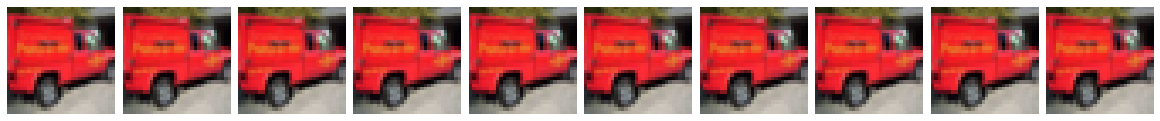

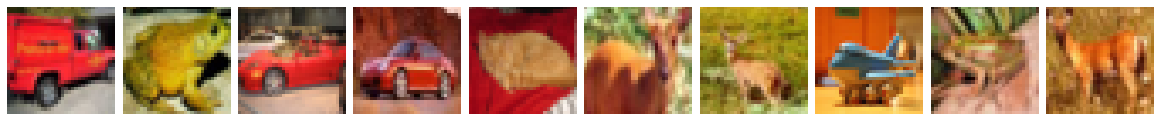

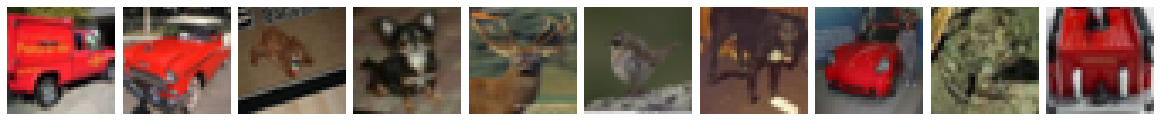

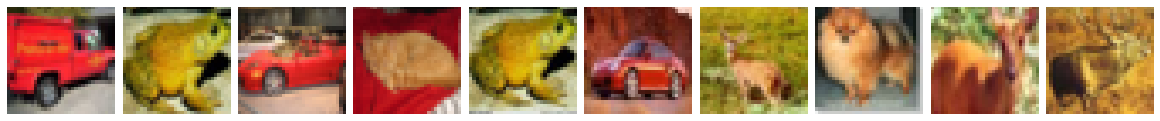




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


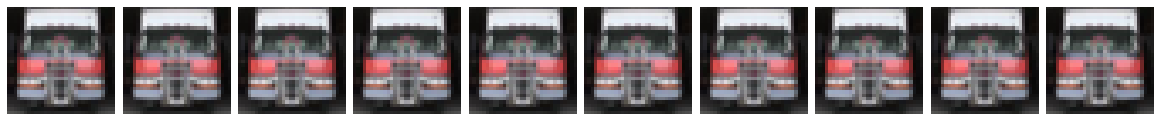

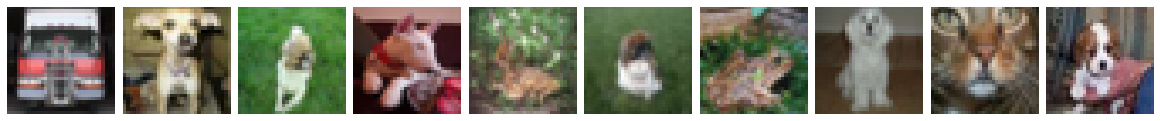

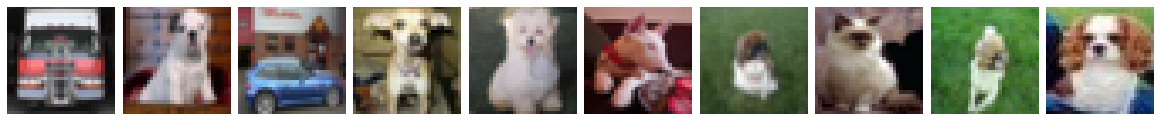

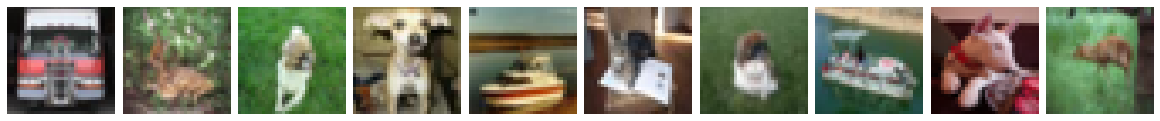




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


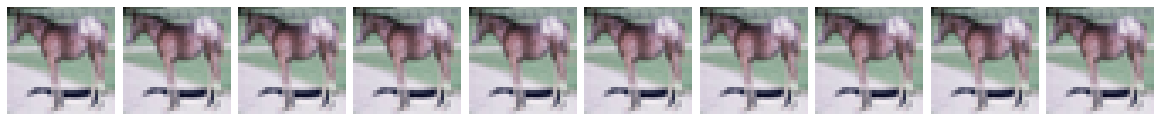

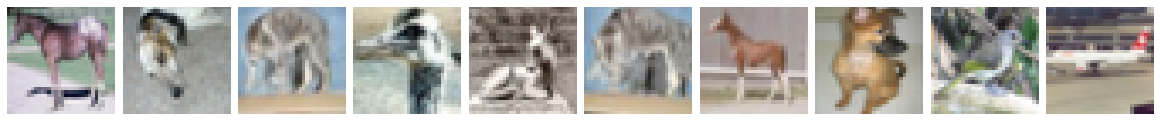

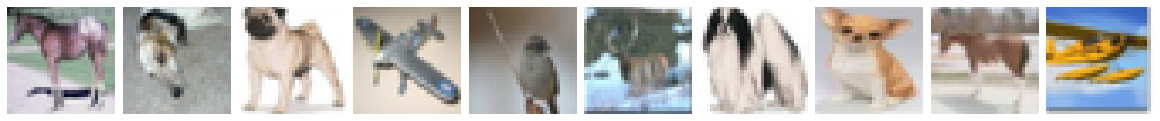

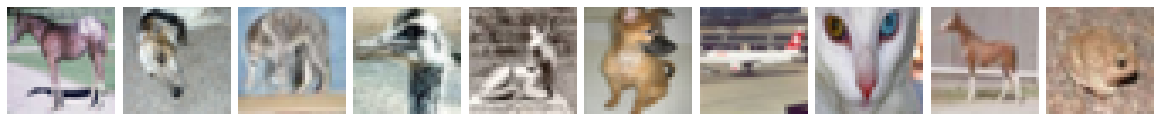




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


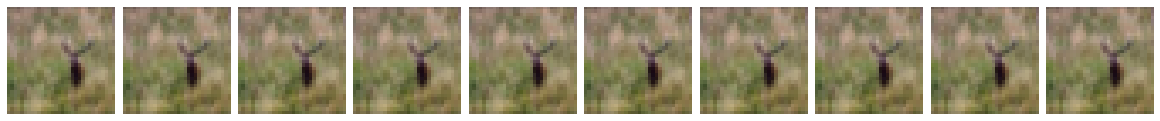

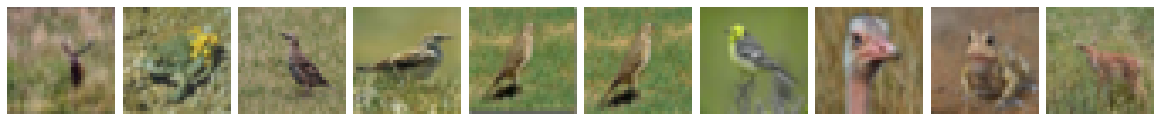

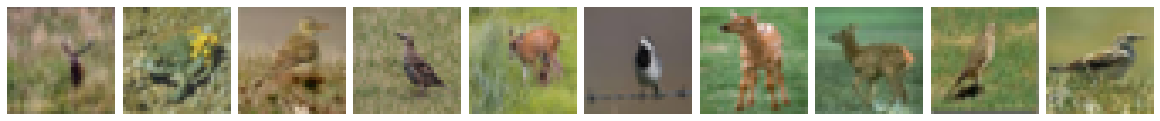

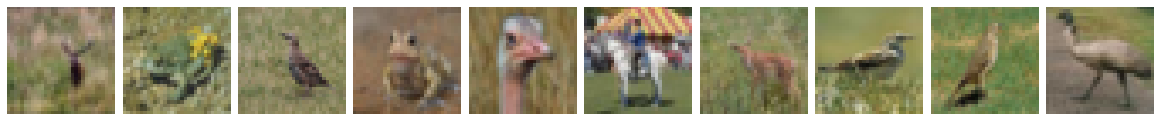




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


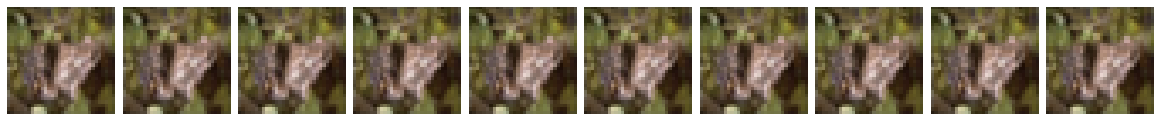

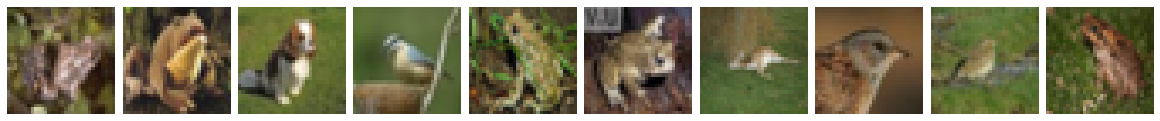

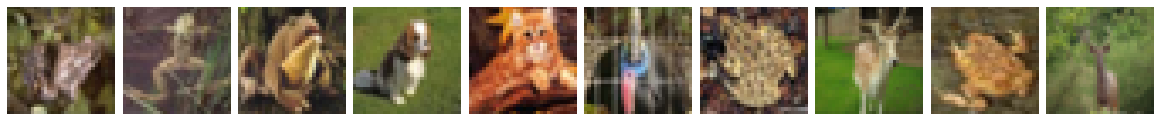

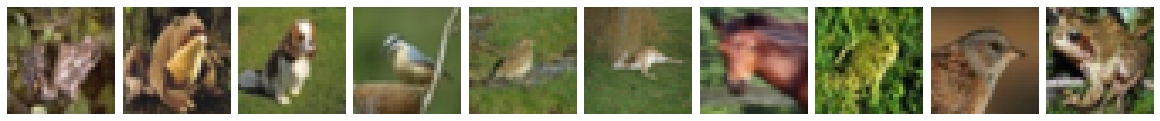




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


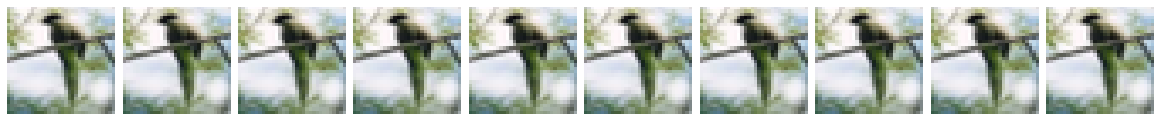

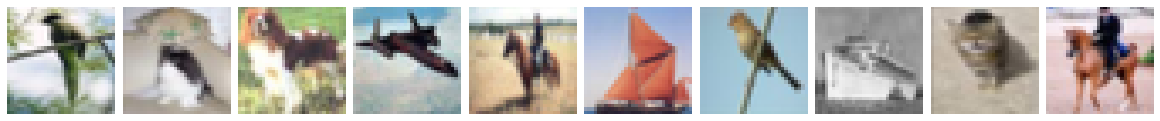

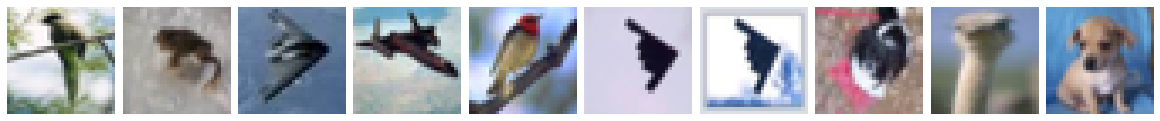

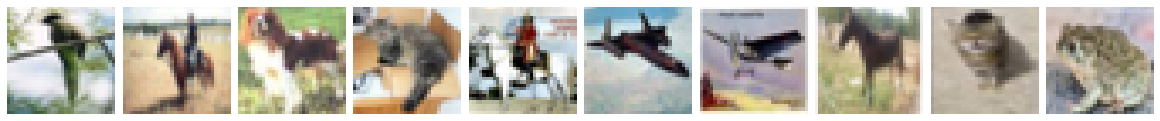




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


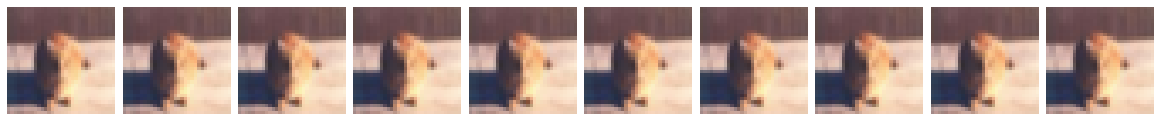

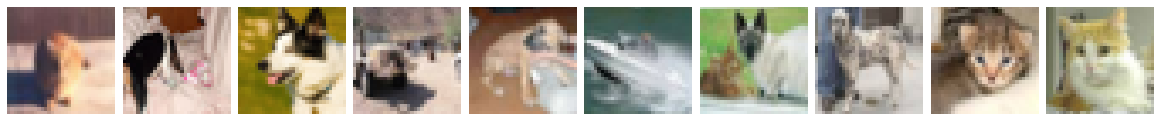

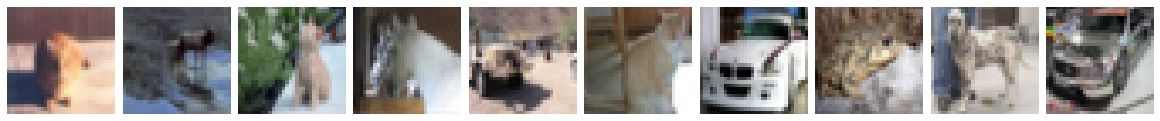

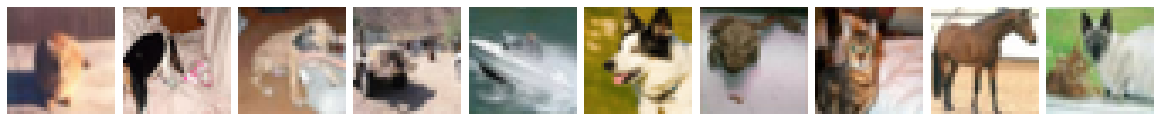




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


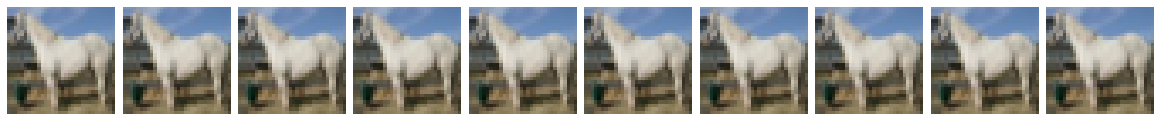

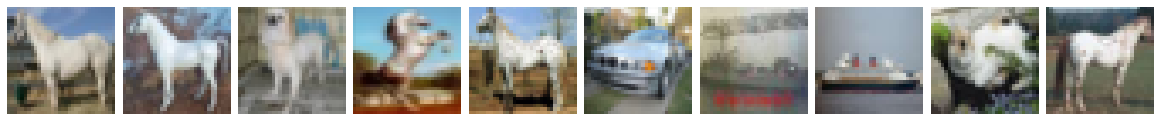

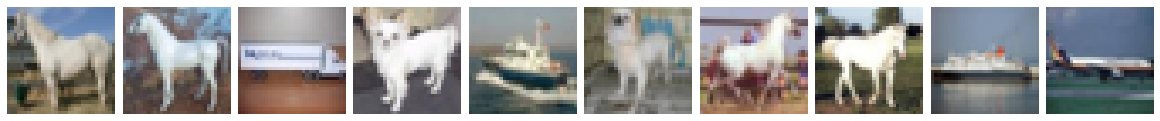

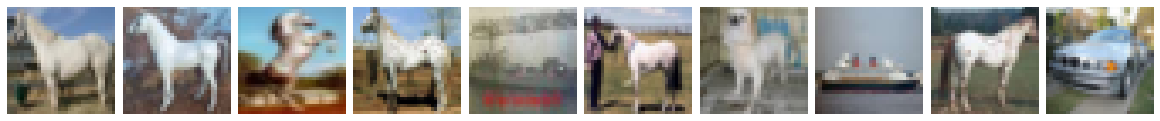




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


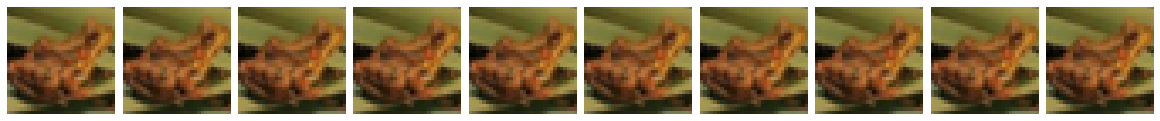

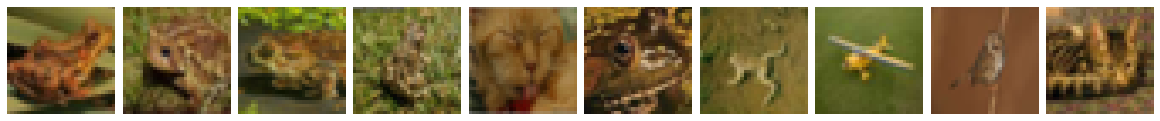

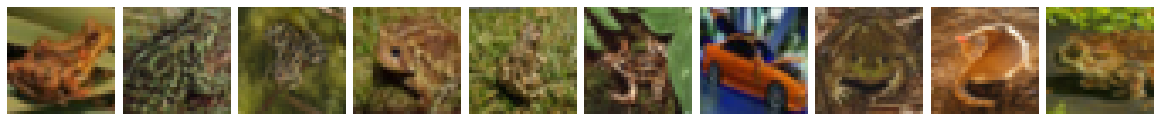

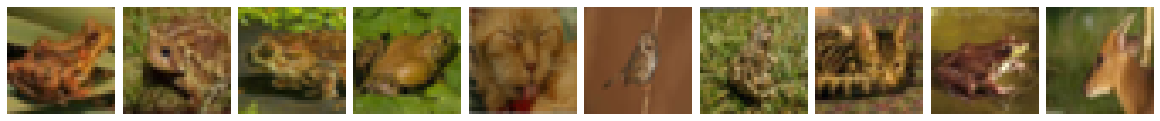




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


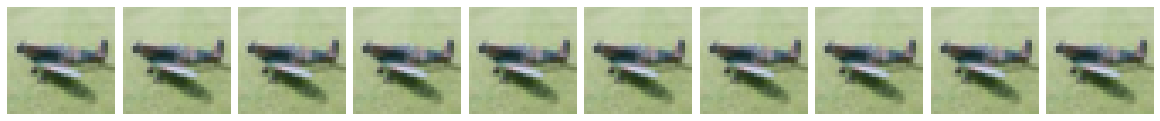

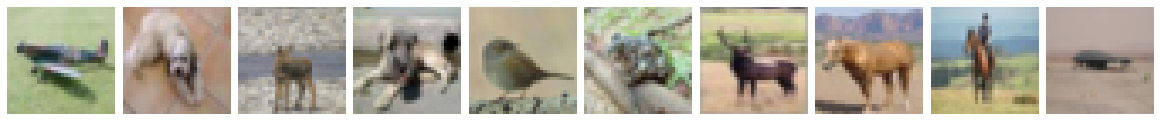

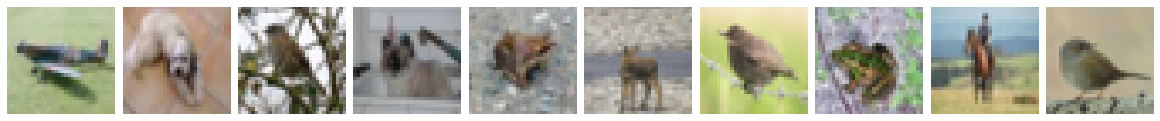

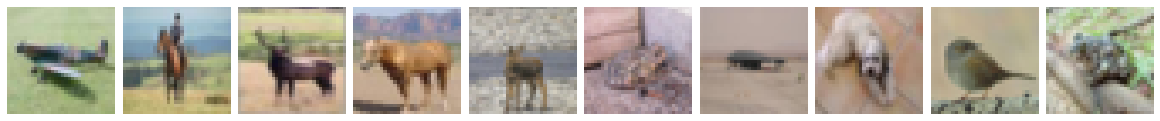




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


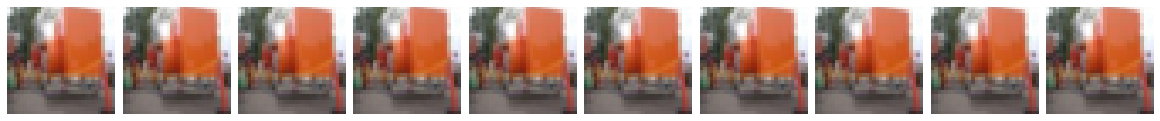

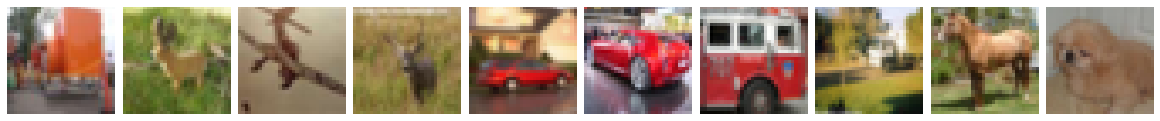

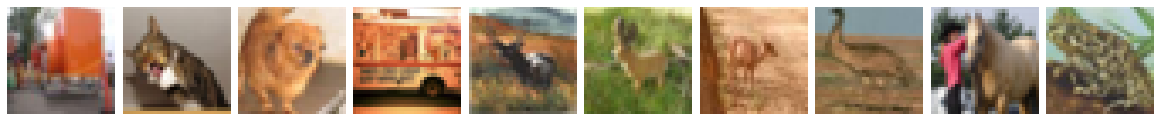

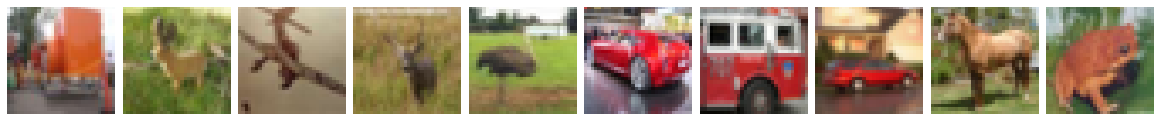




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


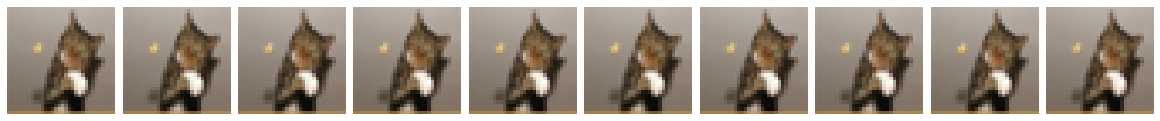

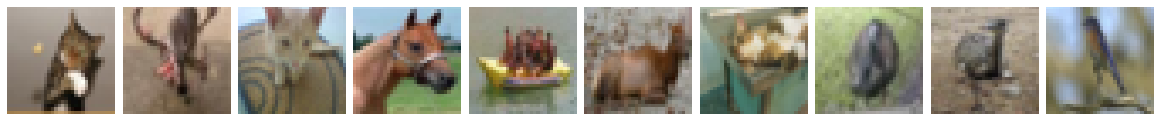

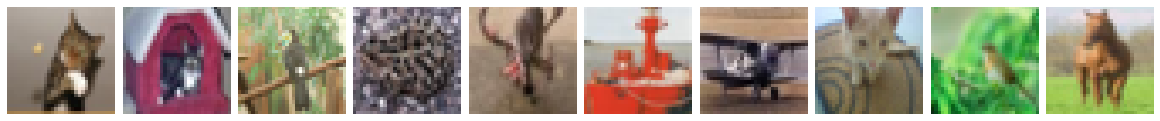

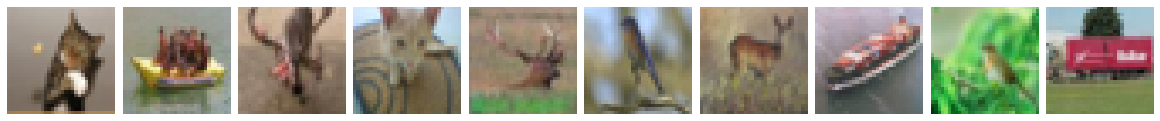




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


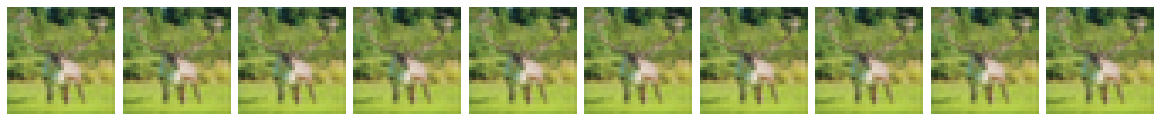

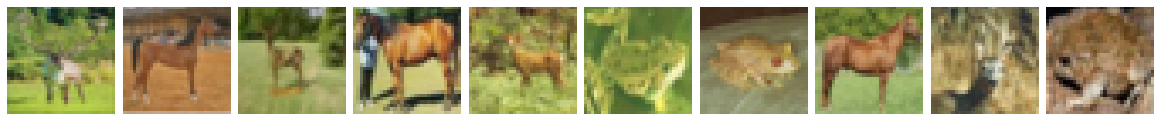

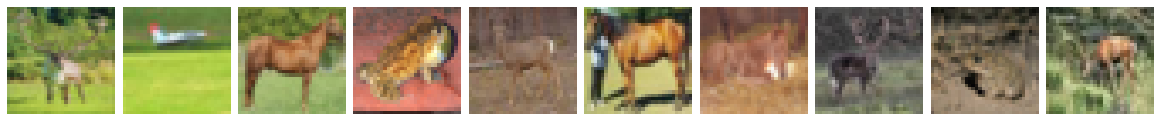

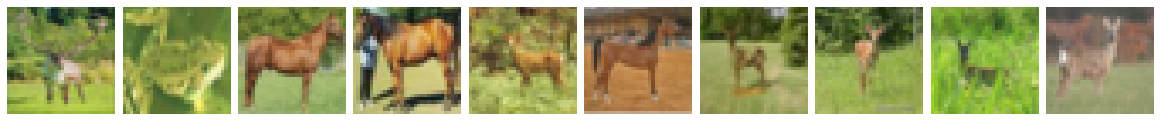




First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query


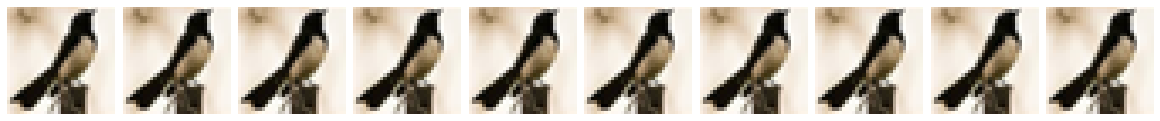

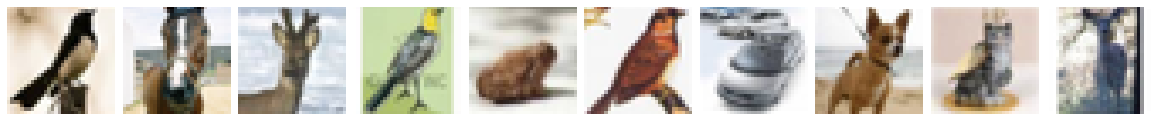

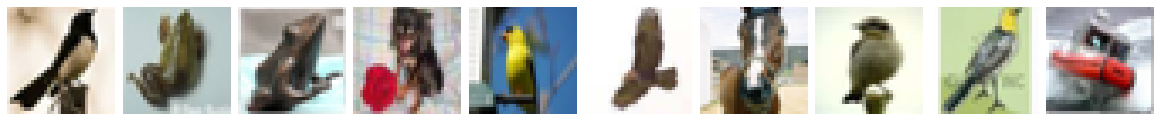

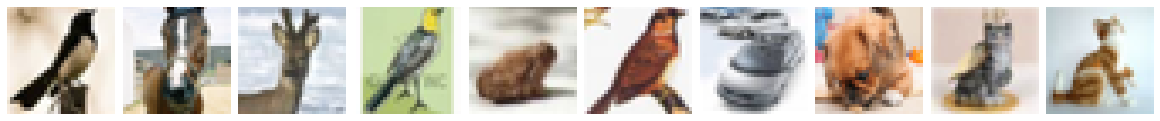

In [38]:
# Visualizing most similar images according to choosen metric
for j, q_image in enumerate(query_images_latentspace):
  dist_dict_eucl, dist_dict_cosine, dist_dict_manhattan = {},{},{} 
  for i, img in enumerate(train_test_latentspaces):
    # Calculating distances for three distance metrics i.e. euclidean distance, manhattan distance and cosine similarity
    dist_dict_eucl[i] = sklearn.metrics.pairwise_distances((q_image, img), metric="euclidean")[0][1]
    dist_dict_cosine[i] = sklearn.metrics.pairwise_distances((q_image, img), metric="cosine")[0][1]
    dist_dict_manhattan[i] = sklearn.metrics.pairwise_distances((q_image, img), metric="manhattan")[0][1]
 
  # Extracting top 10
  top10_eucl = sorted(dist_dict_eucl.items(), key=lambda x: x[1])[:10]
  top10_cosine = sorted(dist_dict_cosine.items(), key=lambda x: x[1])[:10]
  top10_manhattan = sorted(dist_dict_manhattan.items(), key=lambda x: x[1])[:10]

  print("First row original image - Second row euclidean distance similarity query - Third row cosine similarity query - Fourth row manhattan distance similarity query")
  f, axarr = plt.subplots(1, 10, constrained_layout=True)
  f.set_size_inches(16, 6)
  for i, k in enumerate(top10_eucl):
      axarr[i].imshow(x_test[query_image_tuple[j][0]])
      axarr[i].axis('off')
  f, axarr = plt.subplots(1, 10, constrained_layout=True)
  f.set_size_inches(16, 6)
  for i, k in enumerate(top10_eucl):
      prediction = data[k[0]]
      axarr[i].imshow(prediction)
      axarr[i].axis('off')
  f, axarr = plt.subplots(1, 10, constrained_layout=True)
  f.set_size_inches(16, 6)
  for i, k in enumerate(top10_cosine):
      prediction = data[k[0]]
      axarr[i].imshow(prediction)
      axarr[i].axis('off')
  f, axarr = plt.subplots(1, 10, constrained_layout=True)
  f.set_size_inches(16, 6)
  for i, k in enumerate(top10_manhattan):
      prediction = data[k[0]]
      axarr[i].imshow(prediction)
      axarr[i].axis('off')
  plt.show()
  print("\n\n")


## Bonus: Improving Stability

## 6.1 Pre-processing

In [60]:
# Adds random gaussian noise
def gaussian_noise(image):
  return ski.util.random_noise(image, mode="gaussian")

# Applies projective transformations such as rotation or swriling
def projective_transformation(image):
  rint = random.randint(0, 10)
  if rint < 4:
    # rotates the image
    return ski.transform.rotate(image, angle=random.randint(0,360))
  if rint > 4 and rint <= 8:
    # swirls the image (example: https://th.bing.com/th/id/OIP.gHzq_ID68TBu5r2vvW8omAHaE7?pid=Api&rs=1)
    return ski.transform.swirl(image)
  if rint > 8:
    # rotates the image and swirls it afterwards
    return ski.transform.swirl(ski.transform.rotate(image, angle=random.randint(0,360)))

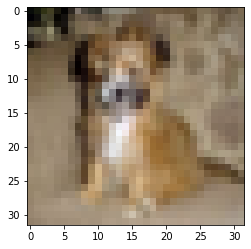

In [62]:
# Original image
plt.imshow(x_train[0])

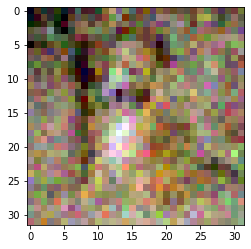

In [63]:
# Example for gaussian noise
plt.imshow(gaussian_noise(x_train[0]))

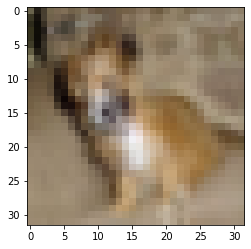

In [64]:
# Example for projective transformations
plt.imshow(projective_transformation(x_train[0]))

## 6.2 Re-training

In [72]:
# Custom Data Generator to alter training data during training
class DataGenerator(Sequence):

    def __init__(self, batchSize, data):
        self.batchSize = batchSize
        self.epoch = 0
        self.xTrain = data
        self.yTrain = data

    def __len__(self):
        return self.xTrain.shape[0]//self.batchSize

    def __getitem__(self, index):
        return (self.xTrain[index*self.batchSize:(index+1)*self.batchSize:], self.xTrain[index*self.batchSize:(index+1)*self.batchSize:])

    def on_epoch_end(self):
        self.epoch += 1
        print(self.xTrain.shape)
        if self.epoch == 10 or self.epoch == 20:
          print("Added noise")
          self.xTrain, self.yTrain = self.modifyImage(self.xTrain)
        
    def modifyImage(self, xTrain):
      original = xTrain
      sample = random.sample(list(xTrain), 1000)
      noisy_sample = []
      for i, s in enumerate(sample):
        if i < 500:
          noisy_sample.append(gaussian_noise(s))
        else:
          noisy_sample.append(projective_transformation(s))
      xTrainOrig = np.vstack((xTrain, np.asarray(sample)))
      xTrainNoise = np.vstack((xTrain, noisy_sample))
      return xTrainNoise, xTrainOrig

In [73]:
# Combining encoder and decoder to autoencoder model
noise_autoencoder_outputs = decoder(encoder(i))
noise_autoencoder = Model(i, noise_autoencoder_outputs, name='noise_autoencoder')

In [ ]:
checkpoint = ModelCheckpoint('best_transform.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
noise_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
training_generator = DataGenerator(512, x_train)
validation_generator = DataGenerator(512, x_val)
history = noise_autoencoder.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=50, callbacks=[checkpoint, earlystopping])

Epoch 1/50
27/88 [========>.....................] - ETA: 4:12 - loss: 0.0235 - accuracy: 0.5746